In [1]:
import imutils
import cv2
from matplotlib import pyplot as plt
import numpy as np
from collections import OrderedDict
import math

path = 'CapturedImage.png'



In [2]:
image = cv2.imread(path)


In [3]:
from scipy.spatial import distance as dist
class ColorLabeler:
    def __init__(self):
        # initialize the colors dictionary, containing the color
        # name as the key and the RGB tuple as the value
        colors = OrderedDict({
            "orange": (255, 95, 0),
            "green": (0, 155, 130),
            "yellow": (210, 170, 0),
            "black": (50, 50, 50),
            "red": (255, 0, 0),
            "blue": (0, 90, 150)})
        # allocate memory for the L*a*b* image, then initialize
        # the color names list
        self.lab = np.zeros((len(colors), 1, 3), dtype="uint8")
        self.colorNames = []
        # loop over the colors dictionary
        for (i, (name, rgb)) in enumerate(colors.items()):
            # update the L*a*b* array and the color names list
            self.lab[i] = rgb
            self.colorNames.append(name)
        # convert the L*a*b* array from the RGB color space
        # to L*a*b*
        self.lab = cv2.cvtColor(self.lab, cv2.COLOR_RGB2LAB)
        
    def label(self, image, c):
        # construct a mask for the contour, then compute the
        # average L*a*b* value for the masked region
        mask = np.zeros(image.shape[:2], dtype="uint8")
        cv2.drawContours(mask, [c], -1, 255, -1)
        mask = cv2.erode(mask, None, iterations=2)
        mean = cv2.mean(image, mask=mask)[:3]
        # initialize the minimum distance found thus far
        minDist = (np.inf, None)
        # loop over the known L*a*b* color values
        for (i, row) in enumerate(self.lab):
            # compute the distance between the current L*a*b*
            # color value and the mean of the image
            d = dist.euclidean(row[0], mean)
            # if the distance is smaller than the current distance,
            # then update the bookkeeping variable
            if d < minDist[0]:
                minDist = (d, i)
        # return the name of the color with the smallest distance
        return self.colorNames[minDist[1]]

In [4]:
class ShapeDetector:
    def __init__(self):
        pass
    def detect(self, c):
        # initialize the shape name and approximate the contour
        shape = "unidentified"
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.04 * peri, True)
        #print(approx)
        #print('Moin')
        delta_x = approx[0][0][0] - approx[1][0][0]
        delta_y = approx[0][0][1] - approx[1][0][1]
        theta_radians = math.atan2(delta_y, delta_x)
        #print(theta_radians)
        # if the shape is a triangle, it will have 3 vertices
        if len(approx) == 3:
            shape = "triangle"
        # if the shape has 4 vertices, it is either a square or
        # a rectangle
        elif len(approx) == 4:
            # compute the bounding box of the contour and use the
            # bounding box to compute the aspect ratio
            ((x, y), (w, h), r) = cv2.minAreaRect(approx)
            ar = w / float(h)
            # a square will have an aspect ratio that is approximately
            # equal to one, otherwise, the shape is a rectangle
            shape = "square" if ar >= 0.95 and ar <= 1.05 else "rectangle"
        # if the shape is a pentagon, it will have 5 vertices
        elif len(approx) == 5:
            shape = "pentagon"
        # otherwise, we assume the shape is a circle
        else:
            shape = "circle"
        # return the name of the shape
        try:
            return shape, r
        except:
            return shape, theta_radians

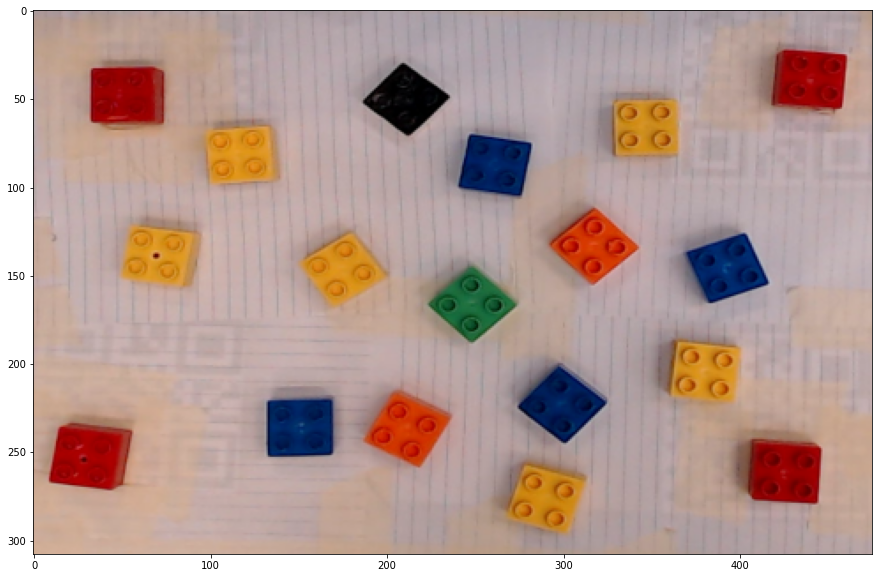

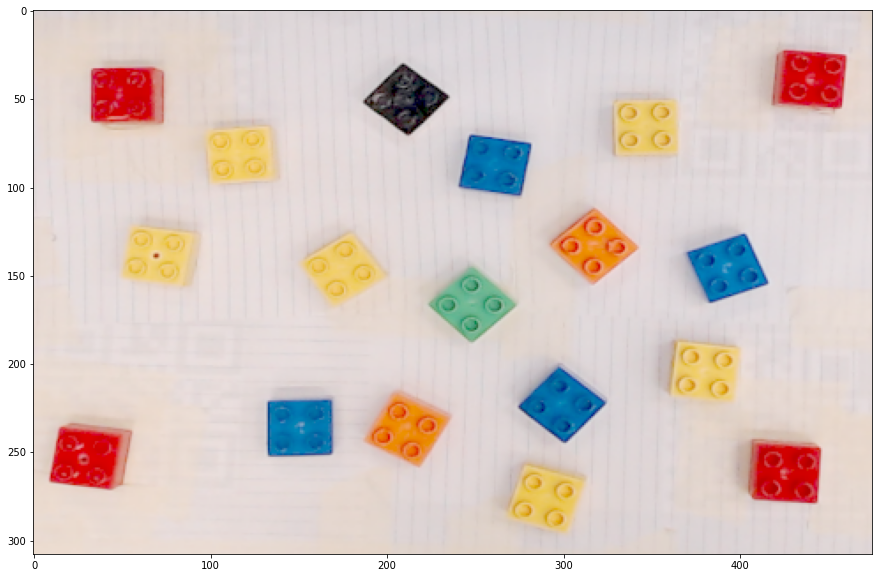

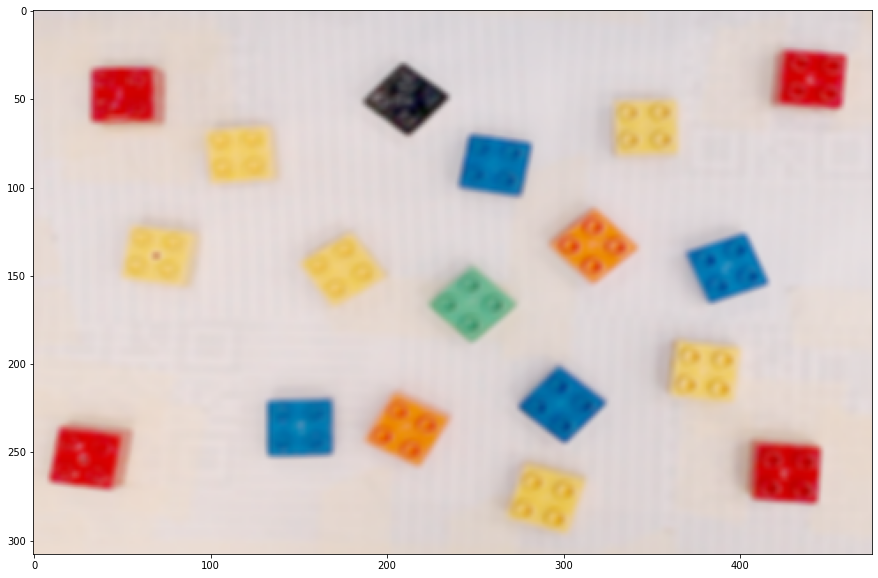

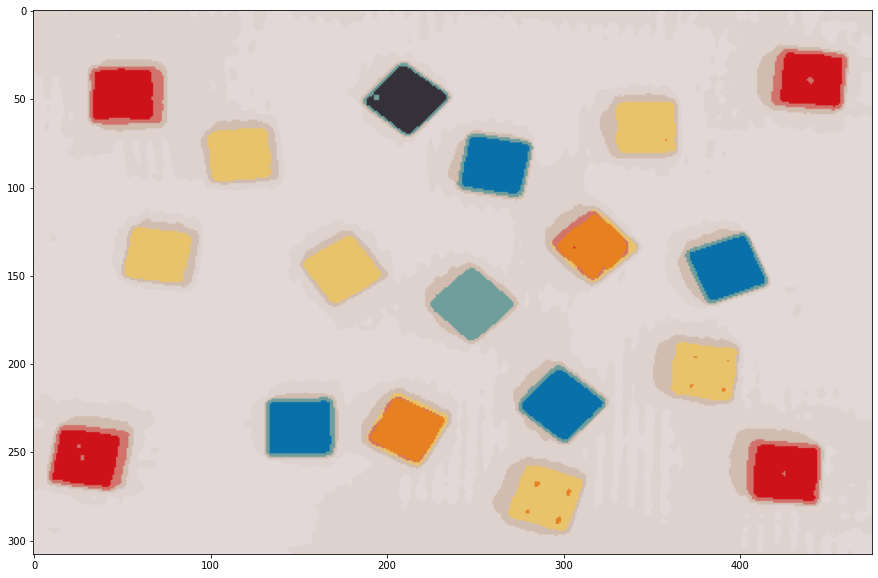

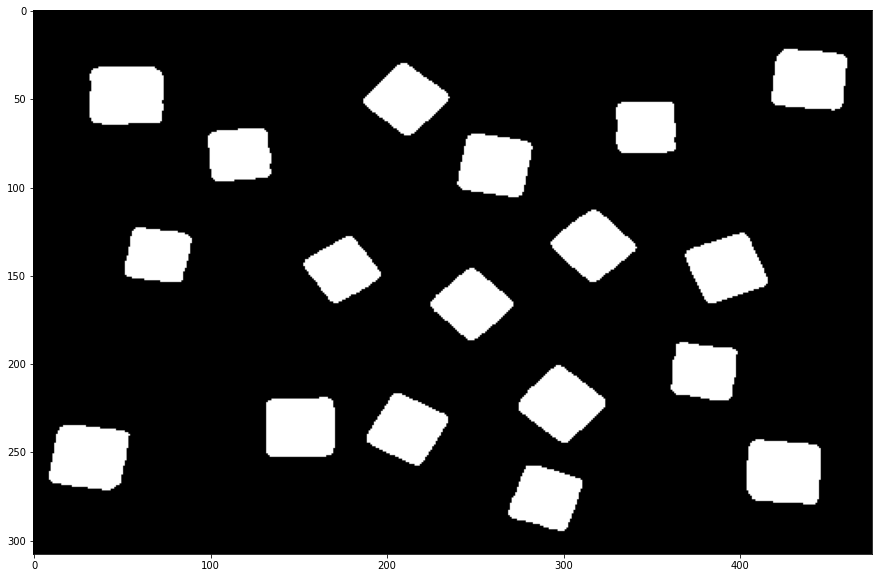

color shape cX cY
yellow rectangle 289 275
red rectangle 424 261
red rectangle 31 252
blue rectangle 150 235
orange rectangle 211 236
blue rectangle 298 222
yellow rectangle 379 204
green rectangle 247 166
yellow rectangle 174 146
blue rectangle 392 145
yellow rectangle 70 138
orange rectangle 316 132
blue rectangle 261 87
yellow rectangle 116 81
yellow rectangle 346 65
red rectangle 52 47
black rectangle 210 50
red rectangle 439 38


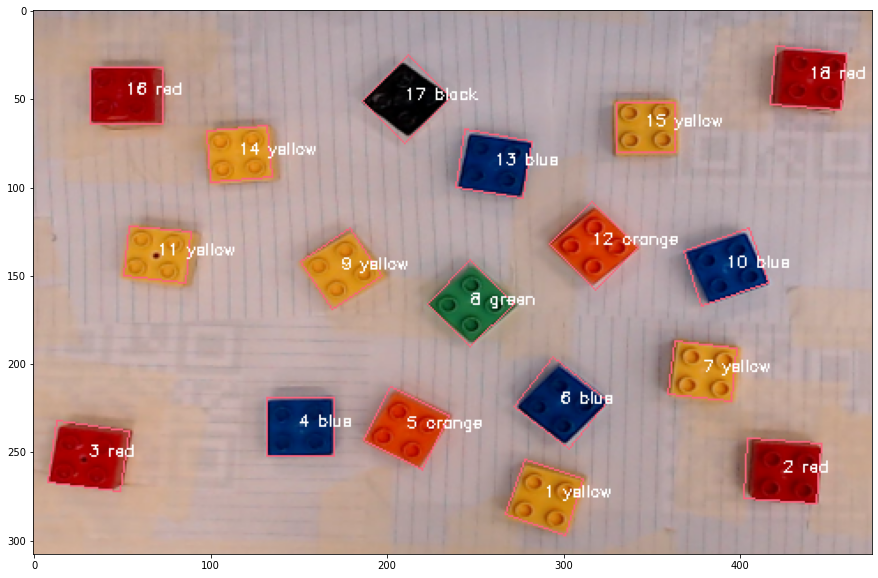

In [5]:
plt.figure(figsize=(20,10))
showim = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(showim)
plt.show()
def adjust_gamma(image, gamma=1.0):
    # build a lookup table mapping the pixel values [0, 255] to
    # their adjusted gamma values
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255
        for i in np.arange(0, 256)]).astype("uint8")
    # apply gamma correction using the lookup table
    LUT = cv2.LUT(image, table)
    return LUT
gamma = adjust_gamma(image, gamma=2.6)
plt.figure(figsize=(20,10))
showim = cv2.cvtColor(gamma, cv2.COLOR_BGR2RGB)
plt.imshow(showim)
cv2.imwrite('1_gamma_mapped.png',cv2.cvtColor(showim, cv2.COLOR_BGR2RGB))
plt.show()
blur = cv2.GaussianBlur(gamma,(5,5),cv2.BORDER_REFLECT)
plt.figure(figsize=(20,10))
showim = cv2.cvtColor(blur, cv2.COLOR_BGR2RGB)
plt.imshow(showim)
cv2.imwrite('2_blurred.png',cv2.cvtColor(showim, cv2.COLOR_BGR2RGB))
plt.show()

criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
K = 10
attempts=10
twoDimage = blur.reshape((-1,3))
twoDimage = np.float32(twoDimage)
ret,label,center=cv2.kmeans(twoDimage,K,None,criteria,attempts,cv2.KMEANS_PP_CENTERS)
center = np.uint8(center)
res = center[label.flatten()]
K_image = res.reshape((image.shape))
plt.figure(figsize=(20,10))
showim = cv2.cvtColor(K_image, cv2.COLOR_BGR2RGB)
plt.imshow(showim)
cv2.imwrite('3_kmean.png',K_image)
plt.show()

lab = cv2.cvtColor(K_image, cv2.COLOR_BGR2LAB)
img_hsv=cv2.cvtColor(K_image, cv2.COLOR_BGR2HSV)
img_gray=cv2.cvtColor(img_hsv, cv2.COLOR_BGR2GRAY)

ret, img_tresh = cv2.threshold(img_gray, 90, 255,cv2.THRESH_BINARY)
ret, B_img_tresh = cv2.threshold(img_gray, 10, 255,cv2.THRESH_BINARY)
B_img_tresh = cv2.bitwise_not(B_img_tresh)
img_tresh = img_tresh + B_img_tresh


plt.figure(figsize=(20,10))
showim = cv2.cvtColor(img_tresh, cv2.COLOR_BGR2RGB)
plt.imshow(showim)
cv2.imwrite('4_colorspace_conv_and_thresh.png',cv2.cvtColor(showim, cv2.COLOR_BGR2RGB))
plt.show()
arr_cnt = cv2.findContours(img_tresh, cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(arr_cnt)
sd = ShapeDetector()
cl = ColorLabeler()
i=1
# loop over the contours
print("color","shape","cX","cY")
for c in cnts:
    # compute the center of the contour, then detect the name of the
    # shape using only the contour
    M = cv2.moments(c)
    if M["m00"] == 0:
        continue
    cX = int((M["m10"] / M["m00"]))
    cY = int((M["m01"] / M["m00"]))
    shape, rotation = sd.detect(c)
    color = cl.label(lab, c)
    # multiply the contour (x, y)-coordinates by the resize ratio,
    # then draw the contours and the name of the shape on the image
    c = c.astype("float")
    c = c.astype("int")
    print(color,shape,cX,cY)
    box = cv2.boxPoints(cv2.minAreaRect(c))
    box = np.intp(box) #np.intp: Integer used for indexing (same as C ssize_t; normally either int32 or int64)
    cv2.drawContours(image, [box], 0, (125, 100, 250))
    cv2.putText(image,str(i)+' '+color, (cX, cY), cv2.FONT_HERSHEY_SIMPLEX, 0.3, (255, 255, 255), 1)
    i+=1
plt.figure(figsize=(20,10))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
cv2.imwrite('5_detected.png',cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()

In [6]:
"""
For homography 
↓↓↓↓uv coordinates↓↓↓↓
red rectangle 31 252
red rectangle 52 47
red rectangle 439 38
red rectangle 424 261

↓↓↓↓world coordinates(using robot)↓↓↓↓
x -446.7 y -368.5
x -296.7 y -225.1
x -34.9 y -450.6
x -196.8 y -603.5"""

'\nFor homography \n↓↓↓↓uv coordinates↓↓↓↓\nred rectangle 31 252\nred rectangle 52 47\nred rectangle 439 38\nred rectangle 424 261\n\n↓↓↓↓world coordinates(using robot)↓↓↓↓\nx -446.7 y -368.5\nx -296.7 y -225.1\nx -34.9 y -450.6\nx -196.8 y -603.5'

In [7]:
# to calculate the transformation matrix
input_pts = np.float32([[31, 252],[52, 47],[439, 38],[424, 262]])
output_pts = np.float32([[-446.7, -368.5],[-296.7, -225.1],[-34.9, -450.6],[-196.8, -603.5]])


# Compute the perspective transform M
H = np.float32(cv2.getPerspectiveTransform(input_pts,output_pts))
print('Homography Matrix: \n', H)

Homography Matrix: 
 [[ 6.63557470e-01 -7.19175935e-01 -2.99773651e+02]
 [-6.26930237e-01 -8.10237169e-01 -1.56216492e+02]
 [ 4.87388934e-05  1.16025236e-04  1.00000000e+00]]


In [8]:
transform_points = input_pts.reshape(-1,1,2).astype(np.float32)

#apply homography transfrom
cartesian_points = cv2.perspectiveTransform(transform_points, H)
reduced_cartesian_points = np.squeeze(cartesian_points, axis=1)

In [9]:
"""For printing world coordinates to validate on robot"""""
image = cv2.imread(path)
def adjust_gamma(image, gamma=1.0):
    # build a lookup table mapping the pixel values [0, 255] to
    # their adjusted gamma values
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255
        for i in np.arange(0, 256)]).astype("uint8")
    # apply gamma correction using the lookup table
    LUT = cv2.LUT(image, table)
    return LUT
gamma = adjust_gamma(image, gamma=2.6)

criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
K = 10
attempts=10
twoDimage = blur.reshape((-1,3))
twoDimage = np.float32(twoDimage)
ret,label,center=cv2.kmeans(twoDimage,K,None,criteria,attempts,cv2.KMEANS_PP_CENTERS)
center = np.uint8(center)
res = center[label.flatten()]
K_image = res.reshape((image.shape))

lab = cv2.cvtColor(K_image, cv2.COLOR_BGR2LAB)
img_hsv=cv2.cvtColor(K_image, cv2.COLOR_BGR2HSV)
img_gray=cv2.cvtColor(img_hsv, cv2.COLOR_BGR2GRAY)

ret, img_tresh = cv2.threshold(img_gray, 90, 255,cv2.THRESH_BINARY)
ret, B_img_tresh = cv2.threshold(img_gray, 10, 255,cv2.THRESH_BINARY)
B_img_tresh = cv2.bitwise_not(B_img_tresh)
img_tresh = img_tresh + B_img_tresh

arr_cnt = cv2.findContours(img_tresh, cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(arr_cnt)
sd = ShapeDetector()
cl = ColorLabeler()
i=1
# loop over the contours
print("color","number","X","Y","rotation")
for c in cnts:
    # compute the center of the contour, then detect the name of the
    # shape using only the contour
    M = cv2.moments(c)
    if M["m00"] == 0:
        continue
    cX = int((M["m10"] / M["m00"]))
    cY = int((M["m01"] / M["m00"]))
    shape, rotation = sd.detect(c)
    color = cl.label(lab, c)
    # multiply the contour (x, y)-coordinates by the resize ratio,
    # then draw the contours and the name of the shape on the image
    c = c.astype("float")
    c = c.astype("int")
    
    world_coords = np.squeeze(cv2.perspectiveTransform(np.float32([cX,cY]).reshape(-1,1,2).astype(np.float32), H), axis=1)[0]
    print(color, i,cX,cY, rotation)
    print('world coodinates: ', world_coords[0], world_coords[1])
    i+=1

color number X Y rotation
yellow 1 289 275 14.931416511535645
world coodinates:  -292.33377 -535.5818
red 2 424 261 3.012787342071533
world coodinates:  -196.13742 -602.79565
red 3 31 252 4.513988018035889
world coodinates:  -446.7 -368.5
blue 4 150 235 1.5911402702331543
world coodinates:  -356.90573 -425.93433
orange 5 211 236 24.145544052124023
world coodinates:  -317.52856 -462.30176
blue 6 298 222 35.134193420410156
world coodinates:  -251.5574 -502.66608
yellow 7 379 204 6.709836959838867
world coodinates:  -187.11214 -536.50256
green 8 247 166 38.36748504638672
world coodinates:  -247.51138 -432.04517
yellow 9 174 146 60.01836013793945
world coodinates:  -282.1422 -374.0876
blue 10 392 145 71.56505584716797
world coodinates:  -138.94736 -501.4411
yellow 11 70 138 10.954063415527344
world coodinates:  -345.85333 -305.9714
orange 12 316 132 40.0302619934082
world coodinates:  -179.50684 -447.53104
blue 13 261 87 9.462322235107422
world coodinates:  -184.93417 -381.62903
yellow 14 